# Putting IPEDS Completions Data into Panels

The U.S. Department of Education's Integrated Postseconday Educational Data System (IPEDS) is a rich source of public data for education researchers and talent acquisition planners.  In particular, the data on the number of degrees awarded by each institution (a.k.a. degree "completions") are very useful for anyone who wants to understand the availability of talent with a particular academic background, and how that varies by geographic location, diversity factors (such as ethnicity or gender), and time. 

It's easy enough to download the IPEDS completions data for an individual year.  But what if we want to analyze changes over time?  Unfortunately, IPEDS has made several changes to its reporting format over the years, including:
* Changes in both file and field naming conventions,
* Differences in which fields are included in which file,
* Inconsistencies in the order of fields across files, and
* Changes to the encoding system of the Classification of Instructional Programs (CIP), which indicates the academic program for which a degree was awarded.

The first half of this iPython notebook contains a script that: 
* Downloads the completions data for every fifth year since 1980 (i.e. 1980, 1985,...2015),
* Standardizes the various file- and field-level differences across the files, and then
* Merges those individual files into one Pandas dataframe with a (year x institution x academic program) panel structure.

The second half of this notebook demonstrates the type of analyses that can be performed on these data.  It uses computer science and related disciplines (CIP codes under category #11) as an example.

### A few notes of caution/interest:
* The mechanism used by the script to download and extract the files relies on iPython "magic" to invoke a bash command.  It won't work if run in a "vanilla" Python environment, and won't work on a Windows box.
* Just to be super-explicit about this:  The script will download a bunch of files and put them on your hard drive, in whatever working directory you've set iPython to use.
* For now, the scope is limited to gender-based breakouts of degree completions (i.e. men vs. women).  Ethnicity-based breakouts are also available in the raw data, and I may add them in the future.
* If all you're interested in are national-level aggregations of the data, this is overkill.  The Digest of Education Statistics has tables of such aggregates available at https://nces.ed.gov/Programs/digest/. 

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [191]:
url_stub = 'https://nces.ed.gov/ipeds/datacenter/data/'

# We want the completions file for each year divisible by 5 since 1980.
years = [year for year in range(1980, 2016, 5)]

# The first four files don't have a regular pattern to the filenames...
file_stubs = ['c1980_4ormore_cip', 'c1985_cip', 'c8990cip', 'c9495_a']

# ...but the last four do.
file_stubs += ['c' + str(year) + '_a' for year in years[-4:]]

# Now we get each file, unzip it, and save the csv to the working directory
for f in file_stubs:
    request = url_stub + f + '.zip'
    !curl $request | tar -x         # bash command

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  327k  100  327k    0     0   138k      0  0:00:02  0:00:02 --:--:--  138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  537k  100  537k    0     0   126k      0  0:00:04  0:00:04 --:--:--  126k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  649k  100  649k    0     0   224k      0  0:00:02  0:00:02 --:--:--  224k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1835k  100 1835k    0     0   187k      0  0:00:09  0:00:09 --:--:--  180k
  % Total    % Received % Xferd  Average Speed   Tim

In [192]:
# One tricky thing:  some of the zip files we unpacked have two versions
# of the data -- an original version and a revised version (designated with 
# _rv at the end of the filename).

ls = !ls   # bash command, equivalent to os.listdir()

for i, f in enumerate(file_stubs):
    original_filename = f + '.csv'
    revised_filename = f + '_rv.csv'
    
    if revised_filename in ls:
        !rm $original_filename       # cleans up the local directory
        file_stubs[i] = f + '_rv'    # ensures our import in the next chunk will work

filenames = [f + '.csv' for f in file_stubs]

In [193]:
# read in each csv as a pandas dataframe 
# and conform them to a common format

pre2006_cols = ['unitid', 'cipcode', 'awlevel', 'crace15', 'crace16']
post2006_cols = ['UNITID', 'CIPCODE', 'AWLEVEL', 'CTOTALM', 'CTOTALW']
master_cols = [col.lower() for col in post2006_cols]
dfs_dict = {}

for (year, filename) in zip(years, filenames):         
    # for now, we need to preserve the leading zeroes in the CIP codes
    df = pd.read_csv(filename, dtype = {'cipcode': str, 'CIPCODE': str})
    
    # drop excess columns and standardize order
    if year < 2006:
        df = df.reindex(columns= pre2006_cols)
    else:
        df = df.reindex(columns= post2006_cols)
    
    # standardize column naming across all dfs
    df.columns = master_cols
    
    # we need to keep track of year when we concatenate all the dfs
    df.insert(0, 'year', year)  
    
    dfs_dict[year] = df

In [194]:
for year, df in dfs_dict.items():
    print(year)
    print(df.info())
    print(df.head())
    print('\n')

1980
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69719 entries, 0 to 69718
Data columns (total 6 columns):
year       69719 non-null int64
unitid     69719 non-null int64
cipcode    69719 non-null object
awlevel    69719 non-null int64
ctotalm    69719 non-null int64
ctotalw    69719 non-null int64
dtypes: int64(5), object(1)
memory usage: 3.2+ MB
None
   year  unitid cipcode  awlevel  ctotalm  ctotalw
0  1980  100654   01020        5        6        0
1  1980  100654   01030        5        2        0
2  1980  100654   01080        5        0        2
3  1980  100654   01120        5       14        0
4  1980  100654   01130        5       10        1


1985
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116605 entries, 0 to 116604
Data columns (total 6 columns):
year       116605 non-null int64
unitid     116605 non-null int64
cipcode    116605 non-null object
awlevel    116605 non-null int64
ctotalm    116605 non-null int64
ctotalw    116605 non-null int64
dtypes: int64(5),

In [195]:
# Pre-1990 CIP codes were in a different format, let's 
# standardize them.  While we're at it, let's extract 
# the category from the first two digits.

def modernize_cip(cipcode):
    return cipcode[:2] + '.' + cipcode[2:]

def cip_category(cipcode):
    return np.int16(cipcode[:2])



for year, df in dfs_dict.items():
    if year < 1990:
        df['cipcode'] = df['cipcode'].apply(modernize_cip)
    df['cip_category'] = df['cipcode'].apply(cip_category)



In [196]:
completions_df = pd.concat(dfs_dict.values())
completions_df['total'] = completions_df['ctotalm'] + completions_df['ctotalw']
completions_df['pct_women'] = completions_df['ctotalw'] / completions_df['total']
print(completions_df.info())
print(completions_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448482 entries, 0 to 300262
Data columns (total 9 columns):
year            1448482 non-null int64
unitid          1448482 non-null int64
cipcode         1448482 non-null object
awlevel         1448482 non-null int64
ctotalm         1439230 non-null float64
ctotalw         1441315 non-null float64
cip_category    1448482 non-null int64
total           1432259 non-null float64
pct_women       1243288 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 110.5+ MB
None
   year  unitid cipcode  awlevel  ctotalm  ctotalw  cip_category  total  \
0  1980  100654  01.020        5      6.0      0.0             1    6.0   
1  1980  100654  01.030        5      2.0      0.0             1    2.0   
2  1980  100654  01.080        5      0.0      2.0             1    2.0   
3  1980  100654  01.120        5     14.0      0.0             1   14.0   
4  1980  100654  01.130        5     10.0      1.0             1   11.0   

   pct_wo

### Supplementing the data
We now have a master completions dataframe that we can manipulate to get some insights into trends related to a particular institution or academic program. Two things that would help us in our analysis are:
* A rollup of the total number of degrees granted by an institution in a given year, allowing us to calculate the percentage of all degrees awarded that came from a particular program.
* Institutional characteristics, such as whether it's a public vs. private university.

(There are a LOT of other things we could pull in from IPEDS to supplement the data, but let's concentrate on those two for now!)

In [197]:
bachelors_totals = pd.pivot_table(completions_df[completions_df['awlevel'] == 5],
                               index =['year', 'unitid'],
                               values=['ctotalm', 'ctotalw', 'total'],
                               aggfunc=np.sum)

bachelors_totals.columns = ['total_ba_men', 'total_ba_women', 'grand_total_ba']

print(bachelors_totals.head())

             total_ba_men  total_ba_women  grand_total_ba
year unitid                                              
1980 1213            52.0           214.0           266.0
     1336            98.0             8.0           106.0
     1340            26.0             0.0            26.0
     1351             0.0           148.0           148.0
     1375            24.0            96.0           120.0


In [202]:
# The last thing we need before we can really analyze the data
# is directory info about the universities, keyed on unitid.

directory_request = url_stub + 'HD2015.zip'
!curl $directory_request | tar -x
uni_dir = pd.read_csv('HD2015.csv', encoding='latin-1')
uni_dir.columns = [c.lower() for c in uni_dir.columns]

# There's a lot of info in the directory, let's keep only fields of interest
uni_dir = uni_dir[['unitid',   
                  'instnm',    
                  'stabbr',   # state abbrev. as string; FIPS code also available 
                  'control',  # see codebook below
                  'hbcu',     # historically black flag 
                  'longitud',  
                  'latitude']].set_index('unitid')

# mostly because 'longitud' is an annoying name for a field
uni_dir.columns = ['name', 'state', 'control', 'hbcu', 'longitude', 'latitude']

control_codes = {1: 'Public',
                2: 'Private non-profit',
                3: 'For-profit',
                -3: 'Unknown'}

hbcu_codes = {1: 'HBCU',
             2: 'Not an HBCU'}

print(uni_dir.info())



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1065k  100 1065k    0     0   138k      0  0:00:07  0:00:07 --:--:--  127k
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7647 entries, 100654 to 487728
Data columns (total 6 columns):
name         7647 non-null object
state        7647 non-null object
control      7647 non-null int64
hbcu         7647 non-null int64
longitude    7647 non-null object
latitude     7647 non-null object
dtypes: int64(2), object(4)
memory usage: 418.2+ KB
None


### Exploratory analysis example:  Computer Science completions over time
As an example of the type of analysis we can perform on these data, let's look now at bachelor's degrees awarded for computer science and related disciplines (CIP category #11).

In [198]:
cs_bachelors = completions_df[(completions_df['cip_category'] == 11) &
                             (completions_df['awlevel'] == 5)]
print(cs_bachelors.head())

     year  unitid cipcode  awlevel  ctotalm  ctotalw  cip_category  total  \
86   1980  101709  11.020        5      0.0      1.0            11    1.0   
87   1980  101709  11.050        5      0.0      1.0            11    1.0   
138  1980  100724  11.020        5      0.0      1.0            11    1.0   
139  1980  100724  11.050        5      0.0      1.0            11    1.0   
261  1980  100858  11.020        5      1.0     15.0            11   16.0   

     pct_women  
86      1.0000  
87      1.0000  
138     1.0000  
139     1.0000  
261     0.9375  


In [199]:
cs_by_uni = pd.pivot_table(cs_bachelors, 
                            index=['year', 'unitid'],
                            values=['ctotalm', 'ctotalw', 'total'],
                            aggfunc=np.sum)

cs_by_uni.columns = ['cs_ba_men', 'cs_ba_women', 'cs_ba_total']

cs_by_uni = pd.merge(cs_by_uni, bachelors_totals, 
                     how='inner', 
                     left_index=True, 
                     right_index=True)

cs_by_uni['cs_pct_women'] = cs_by_uni['cs_ba_women'] / cs_by_uni['cs_ba_total']
cs_by_uni['ba_pct_cs'] = cs_by_uni['cs_ba_total'] / cs_by_uni['grand_total_ba']

cs_by_uni = cs_by_uni.reset_index()

cs_by_uni = cs_by_uni.sort_values(['year', 'cs_ba_total'], 
                                  ascending=[True, False])

cs_by_uni = pd.merge(cs_by_uni, uni_dir, 
                     how='inner', 
                     left_on='unitid',
                     right_index=True, 
                     validate='m:1')

print(cs_by_uni.head())


     year  unitid  cs_ba_men  cs_ba_women  cs_ba_total  total_ba_men  \
800  1980  230038       90.0         53.0        143.0        4824.0   
891  1980  243221       11.0        126.0        137.0        2150.0   
116  1980  131496       23.0        111.0        134.0        1180.0   
50   1980  110662       24.0        109.0        133.0        4292.0   
787  1980  228778       27.0         97.0        124.0        6842.0   

     total_ba_women  grand_total_ba  cs_pct_women  ba_pct_cs  
800          3486.0          8310.0      0.370629   0.017208  
891          3898.0          6048.0      0.919708   0.022652  
116          1464.0          2644.0      0.828358   0.050681  
50           4122.0          8414.0      0.819549   0.015807  
787          6346.0         13188.0      0.782258   0.009402  


There are a lot of universities in the file.  For plotting purposes, we may want to constrain our analysis to institutions that were on the "leaderboard" for most degrees granted at some point over the time series, or perhaps to those that had the highest concentration of students majoring in CS.

In [205]:
top_unis_limit = 20
top_unis_by_size = pd.DataFrame(columns=['unitid', 'name']).set_index('unitid')
top_unis_by_pct = pd.DataFrame(columns=['unitid', 'name']).set_index('unitid')

for year in years:
    biggest_unis= cs_by_uni[cs_by_uni['year'] == year].sort_values(
    'cs_ba_total', ascending=False).iloc[:top_unis_limit, [1,10]].set_index('unitid')
    
    top_unis_by_size = pd.concat([top_unis_by_size, biggest_unis]).drop_duplicates()
    
for year in years:
    mostest_unis = cs_by_uni[cs_by_uni['year'] == year].sort_values(
    'ba_pct_cs', ascending=False).iloc[:top_unis_limit, [1,10]].set_index('unitid')
    
    top_unis_by_pct = pd.concat([top_unis_by_pct, mostest_unis]).drop_duplicates()

top_cs_unis = pd.concat([top_unis_by_size, top_unis_by_pct]).drop_duplicates()
    
print(top_unis_by_size)
print(top_unis_by_pct)


                                               name
unitid                                             
230038               Brigham Young University-Provo
243221        University of Puerto Rico-Rio Piedras
131496                        Georgetown University
110662         University of California-Los Angeles
228778            The University of Texas at Austin
236948      University of Washington-Seattle Campus
151351               Indiana University-Bloomington
186380             Rutgers University-New Brunswick
110635            University of California-Berkeley
240444              University of Wisconsin-Madison
174066          University of Minnesota-Twin Cities
204796            Ohio State University-Main Campus
190664                          CUNY Queens College
170976             University of Michigan-Ann Arbor
234076           University of Virginia-Main Campus
196060                               SUNY at Albany
214777    Pennsylvania State University-Main Campus
110705      

In [214]:
top_cs_unis_trend = cs_by_uni[cs_by_uni['unitid'].isin(top_unis_by_size.index)]

Now let's look at some data questions!

At the level of individual universities, has the number of "seats" available in CS programs been growing over time?  One way to check our intuition on this is to look at the institution-level variation in degrees granted:

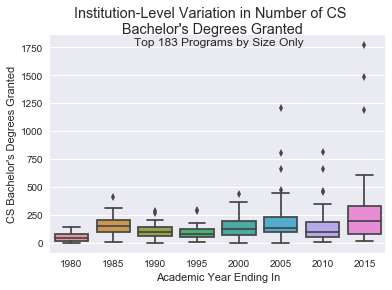

In [258]:
sns.boxplot(x='year', 
            y= 'cs_ba_total', 
           data=top_cs_unis_trend)
plt.suptitle("Institution-Level Variation in Number of CS \nBachelor's Degrees Granted")
plt.text(x=1.5, 
         y=np.max(top_cs_unis_trend['cs_ba_total']), 
         s='Top ' + str(len(top_cs_unis)) + ' Programs by Size Only')
plt.ylabel("CS Bachelor's Degrees Granted")
plt.xlabel('Academic Year Ending In')
plt.show()

Similarly, we might ask whether the decline in the percentage of CS graduates who are women is a problem that spans across multiple institutions, or if it has been concentrated in a few institutions:

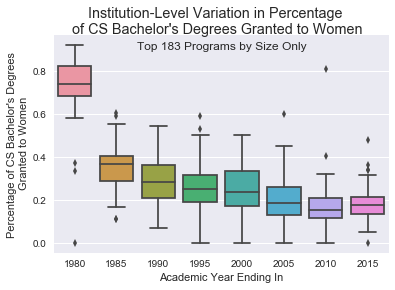

In [257]:
sns.boxplot(x='year', 
           y='cs_pct_women',
           data=top_cs_unis_trend)
plt.suptitle("Institution-Level Variation in Percentage\n of CS Bachelor's Degrees Granted to Women")
plt.text(x=1.5,
        y=.90,
        s='Top ' + str(len(top_cs_unis)) + ' Programs by Size Only')
plt.ylabel("Percentage of CS Bachelor's Degrees\n Granted to Women")
plt.xlabel('Academic Year Ending In')
plt.show()

Or perhaps we'd like to know whether programs that were large in 1985 are still large today:

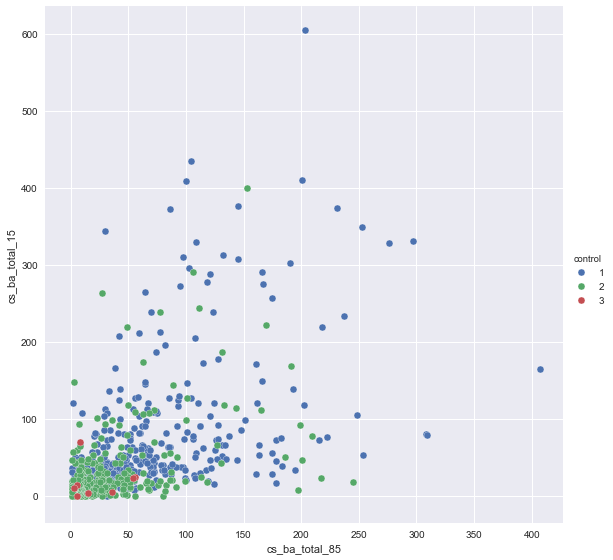

In [255]:
cs_data_1985 = cs_by_uni[cs_by_uni['year'] == 1985].iloc[:, 1:].set_index('unitid')
cs_data_2015 = cs_by_uni[cs_by_uni['year'] == 2015].iloc[:, 1:10].set_index('unitid')
cs_compare_85_15 = pd.merge(cs_data_1985, cs_data_2015, 
                                left_index=True,
                                right_index=True, 
                                suffixes=('_85', '_15'))

sns.pairplot(x_vars=['cs_ba_total_85'],
        y_vars=['cs_ba_total_15'],
        data= cs_compare_85_15,
        hue='control',
        size= 8)
plt.show()
